<img src="images/logo/selene-logo-640.png" style="max-height:75px;" alt="SELENE Logo" />

**Disclaimer:** This Jupyter Notebook contains content generated with the assistance of AI. While every effort has been made to review and validate the outputs, users should independently verify critical information before relying on it. The SELENE notebook repository is constantly evolving. We recommend downloading or pulling the latest version of this notebook from Github.

# The Math Behind Linear Regression

As a quick recap, Linear Regression is a fundamental statistical and machine learning model used to understand and predict relationships between variables. It models the relationship between one or more independent variables $x_1$, $x_2$, ..., $x_n$ and a dependent variable $y$, assuming a linear relationship between them. Mathematically, this relationship is described by the following equation:

$$\large
y_i = w_{0} + w_{1}x_{i1} + w_{2}x_{i2} + w_{3}x_{i3} + \dots + w_{d}x_{id} + e_{i}
$$

with $i = 1,..., n$, where

* $n$ is the number of observations (i.e., the number of records in our dataset)
* $y_i$ is the $i$-th response (e.g., the resale price of an apartment)
* $w_k$ is the $k$-th coefficient, with $w_0$ being the constant term in the model called *bias*, *offset*, or *intercept*
* $x_{ij}$ is the $j$-th predictor variable (e.g., the size of an apartment, or the floor height) of the $i$-th observation
* $e_i$ is the *noise term*, *disturbance term*, or *error variable* of the $i$-th observation

Assuming that the expectation value for the noise terms $E(e_i) = 0$, we can use a Linear Regression model to calculate the $estimated$ or $predicted$ output $\hat{h}_{i}$ for the $i$-th data records as follows:

$$\large
\hat{y}_{i} = E(y_{i}) = w_{0} + w_{1}x_{i1} + w_{2}x_{i2} + w_{3}x_{i3} + \dots + w_{d}x_{id}
$$

We saw that training or fitting a Linear Regression model meant to find the weights $\mathbf{w} = \{w_0, w_1, w_2, \dots, w_d \}$ the yield the best predictions $\hat{y}$ compared to the true values $y$ given by a training dataset. To find those best weights, we first introduced a **loss function** to quantify how well the current set of weights $\mathbf{w}$ performs. We then looked different ways to find the best weights by minimizing the loss function either analytically using the **Normal Equation** or iteratively using methods such as **Gradient Descent**.

In the introductory notebook, we defined the loss function for Linear Regression as the **Mean Squared Error (MSE)** as well as glossed over the mathematical details such as calculating the derivative of the MSE loss function and the definition of the Normal equation. In this notebook, we look into more detail why the MSE is commonly the loss function of choice, as well look into all the mathematical steps involved to train a Linear Regression model.

### Setting up the Notebook

#### Make Required Imports

This notebook requires the import of different Python packages but also additional Python modules that are part of the repository. If a package is missing, use your preferred package manager (e.g., [conda](https://anaconda.org/anaconda/conda) or [pip](https://pypi.org/project/pip/)) to install it. If the code cell below runs with any errors, all required packages and modules have successfully been imported.

In [1]:
from src.utils.libimports.linreg import *
from src.utils.plotting.linreg import *
from src.utils.data.files import *

#### Download Required Data

Some code examples in this notebook use data that first need to be downloaded by running the code cell below. If this code cell throws any error, please check the configuration file `config.yaml` if the URL for downloading datasets is up to date and matches the one on Github. If not, simply download or pull the latest version from Github.

In [2]:
csi_example, _ = download_dataset("tabular/regression/example-csi-height-prediction.csv")

File 'data/datasets/tabular/regression/example-csi-height-prediction.csv' already exists (use 'overwrite=True' to overwrite it).


---

## Choice of Loss Function

### Consideration of Alternatives

To motivate the choice of the MSE as a suitable loss function for Linear Regression, we can look at some alternatives and discuss their pros and cons. To this end, we use the CSI example dataset from the introductory notebooks to better illustrate the behavior of different loss functions. As usual, we first load the dataset file using the pandas library.

In [3]:
df = pd.read_csv(csi_example)

df.head()

shoe print size  height
0             30.3   177.0
1             32.8   187.8
2             27.0   156.5
3             29.4   184.0
4             28.2   162.6

With the provided auxiliary method `plot_csi_data()` we can also plot the dataset together with the regression line representing the true relationship between the input and the output, as well as the error between the prediction and the true values (dashed black lines). The weights $w_0 = 70$ and $w_1 = 3.6$ describing the true relationship are the same as used in the introductory notebook.

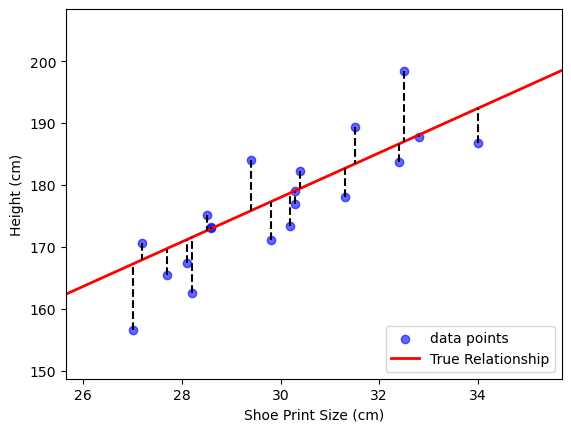

In [4]:
# Extract the data matrix X and the label vector y from DataFrame
X = df[['shoe print size']].to_numpy()
y = df[['height']].to_numpy().squeeze()

# Define define weights describing true relationship
w_true = [70, 3.6]

# Plot data with regression line and errors
plot_csi_data(X.squeeze(), y, regression_lines=[(w_true, "red", "True Relationship")], show_errors=True)

From the plot we can derive that the line that best fits the overall data distribution is the line that minimizes the errors between the predicted and true values. This means that we are looking for weights that yield predictions close to the true values. To quantify the difference between the predicted values $\hat{y}$ and the true values $\mathbf{y}$ with respect to a current set of weights $\mathbf{w}$, we introduced the concept of a loss function L (also called error function or loss function):

$$\large
L(\hat{\mathbf{y}}, \mathbf{y}) = \text{"single value reflecting the difference between estimates/predictions and true values"}
$$

Based on this general requirement for a loss function, there are various approaches to actually implement this function. In the following, we will go through some conceivable alternatives to see how suitable they are for application of a loss function for Linear Regression models.

#### (Simple) Mean Error

The most naive way to calculate the error between the predicted and true values would simply by to calculated the difference between the values, and average the differences across all training data samples:

$$\large
L_{ME}(\hat{\mathbf{y}}, \mathbf{y}) = \frac{1}{n} \sum_i^n (\hat{y}_i - y_i)
$$

Of course, this causes a problem. Since a true value $y_i$ can be smaller or larger than the predicted value $\hat(y)_i$, the error $(\hat{y}_i - y_i)$ can be positive or negative. This means that we might have very large positive and negative errors (i.e., having a bad model) that can still yield a very low loss because the errors cancel each other out during the summation of the errors. In other words, a small loss is not an indicator for a good model. Therefore, the $L_{ME}$ is not an appropriate loss function.

#### Mean Absolute Error (MAE)

One straightforward way to avoid negative errors is to sum up the absolute values between the predicted and true values:

$$\large
L_{MAE}(\hat{\mathbf{y}}, \mathbf{y}) = \sum_i^n \left| \hat{y}_i - y_i \right|
$$

In principle, this is an appropriate loss function as $L$ is minimized (i.e., $L=0$) if all predictions $\hat{y}_i$ match the true values $y_i$; and the larger the differences the larger the loss. The problem with the MAE, however, is that it is mathematically "inconvenient" for the purpose of training a Linear Regression model. To understand this, let's look at the plot of the function $f(x)=|x|$:

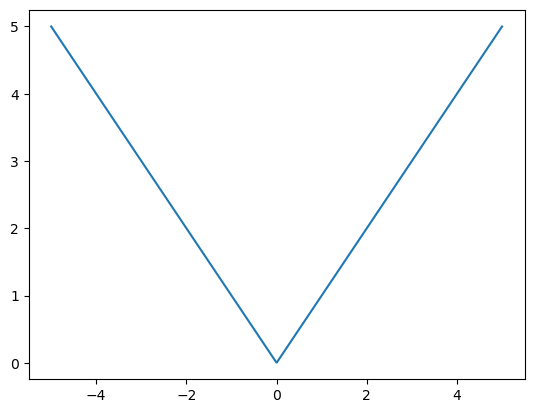

In [5]:
plt.figure()
x = np.linspace(-5, 5, 1000)
plt.plot(x, np.abs(x));
plt.show()

The problem is that the derivative of function $f(x)=|x|$ is

$$\large
\frac{\partial f}{\partial x} = \frac{x}{|x|}
$$

which means that the derivative is not defined for $x=0$. However, we favor loss function $L$ that is differentiable (i.e., the derivative of the function exists at all points) for actually minimizing $L$. In practice, this special case of $x=0$ can be handled separately to use the MAE as a loss function. In practice, we can avoid any special treatment by using the next best alternative to ensure only positive errors, which brings us to the Mean Squared Error (MSE).

#### Mean Squared Error (MSE)

The common alternative to avoid negative errors without using the absolute function is to square the errors, as the square of any number is always positive. This, in fact, is captured by the MSE we introduced as the common loss function to fit Linear Regression Models:

$$\large
L_{MSE}(\hat{\mathbf{y}}, \mathbf{y}) = \sum_i^n (\hat{y}_i - y_i)^{2}
$$

Compared to $L_{MAE}$, the $L_{MSE}$ is also differentiable, allowing for finding its minimum without any handling special cases where the derivative of the $L_{MSE}$ would not be defined. We cover the calculation of the derivative in full detail later in this notebook.

#### Mean Even-Power Error (Mean Even-Power Error)

Given the MSE loss, a possible question might be why not use larger powers (assuming even powers to ensure only positive errors), i.e.:

$$\large
L_{MEPE}(\hat{\mathbf{y}}, \mathbf{y}) = \sum_i^n (\hat{y}_i - y_i)^{k}
$$

where $k = 4, 6, 8, \dots$ is an even number larger than 2. As this loss is also differentiable, it could be indeed considered an appropriate loss function. Compared to the MSE loss (using a power of 2), larger powers make the loss more susceptible to outliner, that is, where the difference between the predicted and true values is very large compared to the average. In fact, it can be argued that the MSE loss is already susceptible due to squaring the errors. Let's have a quick look by converting a single data point in our CSI example dataset to an outlier:

In [6]:
# Create copy to preserve the orignal data
y_with_outlier = np.copy(y)

# Increase the value of a data point by 50%
y_with_outlier[15] *= 1.50

We can now train a Linear Regression model using this modified dataset containing the outlier and again plot the regression line.

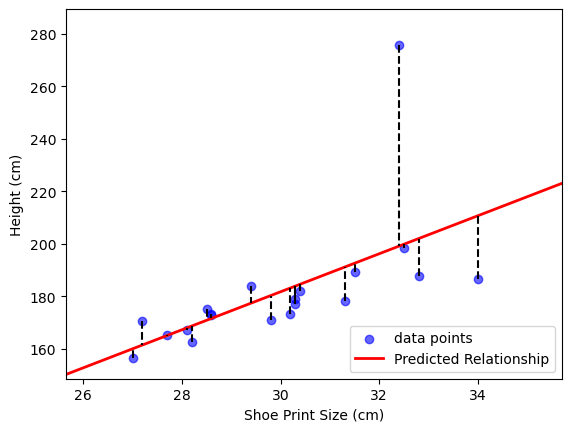

In [7]:
# Train/fit a Linear Regression model based on data with outlier
model_csi = LinearRegression().fit(X, y_with_outlier)

# Extract the weights for plotting the regression line
w_fit = [model_csi.intercept_, model_csi.coef_[0]]

plot_csi_data(X.squeeze(), y_with_outlier, regression_lines=[(w_fit, "red", "Predicted Relationship")], show_errors=True)

Notice how this change of a single data point "pulls" the regression line upwards. This means that even the MSE loss function makes training a Linear Regression potentially quite sensitive to outliers. However, with an even power larger than 2, this effect would be much more pronounced. So the MSE represents a reasonable trade-off.

#### Other Loss Functions

In principle, loss functions can be arbitrarily complex as long as they remain appropriate. To give one example here, a commonly used more complex loss function for regression tasks is the so-called Huber Loss Smooth Mean Absolute Error (SMAE). As the name suggests, it is based on the MAE to be less susceptible to outliers. To avoid the problem that the derivative of the MAE is not defined for errors that are $0$, the Huber loss integrates the MSE loss for small errors. As such the Huber Loss for a single data point is defined as follows:

$$\large
L_{SMAE}(\hat{y}_i, y) =
\begin{cases}
\frac{1}{2}(\hat{y}_i - y_i)^{2} & \text{for } |\hat{y}_i - y_i| \leq \delta\\[0.75em]
\delta |\hat{y}_i - y_i| - \frac{1}{2}\delta^2 & \text{otherwise}
\end{cases}
$$

The definition of the Huber Loss $L_{SMAE}$ ensures that both cases yield the same gradient going towards $|\hat{y}_i - y_i| = \delta$ from either side.

For a better understanding, we can plot the Huber Loss and compare it with the MAE and MSE loss. In the formula above, you can see that the Huber Loss has a parameter $\delta$ to specify the maximum error for the MSE component of the Huber Loss to be used. The code cell below calls an auxiliary method to handle the plotting. You can change the list of `deltas` to try out different $\delta$ values.

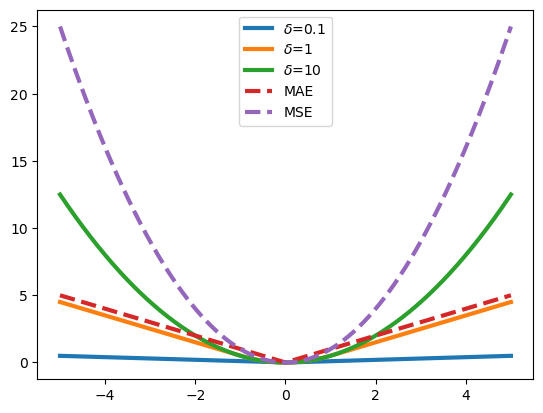

In [8]:
plot_huber_loss(deltas=[0.1, 1, 10], show_mae=True, show_mse=True)

You can see that for $\delta = 1$, the Huber Loss is of very similar scale as the MAE loss. Increasing $\delta$ means that the MSE component of the Huber Loss is used for a larger range of error values. Therefore, the line for $\delta=10$ looks like a parabola, only scaled down by a factor of $1/2$ compared to the line for the MSE loss (notice the factor of $1/2$ in the formula for $L_{SMAE}$ above). For small $\delta$ values, only a small interval around 0 gets captured by the MSE component. Since the derivatives of the MAE and MSE component must yield the same gradient for $|\hat{y}_i - y_i| = \delta$, this also means the MAE component becomes very flat for low $\delta$ values.

### Linear Regression as Statistical Model

So far, we mainly used arguments that the MSE is the most suitable loss function of Linear Regression. The MSE loss is appropriate, differentiable, and not overly susceptible to outliers. However, there is a much more fundamental reason to use the MSE as the loss function when considering Linear Regression as a probabilistic model. Recall that a Linear Regression model was defined as

$$\large
y_i = w_{0} + w_{1}x_{i1} + w_{2}x_{i2} + w_{3}x_{i3} + \dots + w_{d}x_{id} + e_{i}
$$

where we assume that the errors are normally distributed with a mean of $0$ constant variance $\sigma^2$, i.e.:

$$\large e_i \sim N(0, \sigma^2)$$

This allows to treat as $y_i$ a random variable drawn from a Normal Distribution with the constant variance $\sigma^2$ and the mean being the predicted value $\hat{y}_{i}$, i.e., $\mu_{i} = \hat{y}_{i} = \theta^{T}\mathbf{x}_{i}$

$$\large y_i \sim N(\mathbf{w}^{T}\mathbf{x}_{i}, \sigma^2)$$

Using the formula for the Normal Distribution, the probability of $y_i$ can be written as follows:

$$\large P(y_i | \mu_{i}, \sigma^2) = \frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{1}{2\sigma^s}\left(y_i - \mu_{i} \right)^2}$$

With $\mu_{i} = \theta^{T}\mathbf{x}_{i}$, this probability can be further rewritten to

$$\large P(y_i | \mathbf{x_i}; \mathbf{w}, \sigma^2) = \frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{1}{2\sigma^2}\left(y_i - \mathbf{w}^{T}\mathbf{x}_{i} \right)^2}$$

#### Maximum Likelihood Estimation

With $P(y_i | \mathbf{x}_{i}; \theta, \sigma^2)$ we can calculate probability of observing the response $y_i$ given input $\mathbf{x_i}$ and the parameters $\mathbf{W}$ and $\sigma^2$. However, what we are really interested in are the values for the weights $\mathbf{w}$ that maximize the probability. This expressed by the likelihood $\mathcal{L}(\theta|\mathbf{x}_{i}, y_i; \sigma^2)$ - that is, the likelihood that model with parameters $\mathbf{w}$ and $\sigma^2$ produced response $y_i$ from input $\mathbf{x}_{i}$.

The likelihood function $\mathcal{L}$ is equal to the probability density function parameterized by the weights $\mathbf{w}$:

$$\large L(\mathbf{w}|\mathbf{x}_{i}, y_i; \sigma^2) = P(y_i | \mathbf{x}_{i}; \mathbf{w}, \sigma^2) = \frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{1}{2\sigma^2}\left(y_i - \mathbf{w}^{T}\mathbf{x}_{i} \right)^2}$$

We can extend the likelihood for a single data point to the the likelihood over all data points in a dataset:

$$\large L(\mathbf{w}|\mathbf{X}, \mathbf{y}; \sigma^2) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{1}{2\sigma^2}\left(y_i - \mathbf{w}^{T}\mathbf{x}_{i} \right)^2}$$

Let's modify this formula in two ways. Firstly, we apply the logarithm to the product. Using the logarithm rule $\log{mn} = \log{m}+\log{n}$, we can convert the product into a sum. This makes calculating the derivative much easier. Note that we can do this because the logarithm is a monotonically increasing function. This means that the minima or maxima of a function will be at the same input values before and after the application of the logarithm. And secondly, notice that we want to maximize the likelihood. However, we typically consider loss functions to be minimized. Therefore, although not required, we add a minus sign to the likelihood. Both these modifications give us the so-called **Negative Log-Likelihood** $NLL$:

$$
\begin{align}
\large NLL(\mathbf{w}|\mathbf{X}, \mathbf{y}; \sigma^2) &= \large - \log \left[ \prod_{i=1}^{n}  \frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{1}{2\sigma^2}\left(y_i - \mathbf{w}^{T}\mathbf{x}_{i} \right)^2}\right] \\[1.25em]
&= \large - \sum_{i=1}^{n} \log \left[ \frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{1}{2\sigma^2}\left(y_i - \mathbf{w}^{T}\mathbf{x}_{i} \right)^2}\right] \\[1.25em]
\end{align}
$$


We can further simplify this formula by more repeated applications of the logarithm rules $\log{mn} = \log{m}+\log{n}$ as well as $\log{\left(m^k \right)} = k\log{m}$. For even we assume that the logarithm is the natural logarithm, we can also apply the rule $\log_{e}{\left(e^k \right)} = k$, this "bringing down" the exponent of the function of the Normal Distribution:

$$
\begin{align}
\large NLL(\mathbf{w}|\mathbf{X}, \mathbf{y}; \sigma^2) &= \large - \sum_{i=1}^{n} \log \left[ \frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{1}{2\sigma^2}\left(y_i - \mathbf{w}^{T}\mathbf{x}_{i} \right)^2}\right] \\[1.25em]
&= \large - \sum_{i=1}^{n} \left[ \frac{1}{2} \log \frac{1}{\sqrt{2\pi \sigma^2}} - \frac{1}{2\sigma^2} \left(y_i - \mathbf{w}^{T}\mathbf{x}_{i} \right)^2 \right] \\[1.25em]
&= \large - \frac{N}{2} \log \frac{1}{\sqrt{2\pi \sigma^2}} - \frac{1}{2\sigma^2} \sum_{i=1}^{n} \left(y_i - \mathbf{w}^{T}\mathbf{x}_{i} \right)^2 \\[1.25em]
&= \large - \frac{N}{2} \log \frac{1}{\sqrt{2\pi \sigma^2}} - \frac{1}{2\sigma^2} RSS(\mathbf{w}) \\[1.25em]
\end{align}
$$

where $RSS(\mathbf{w}) = \sum_{i=1}^{n} \left(y_i - \mathbf{w}^{T}\mathbf{x}_{i} \right)^2 = \sum_{i=1}^{n} \left(y_i - \hat{y}_{i} \right)^2$ is the **Residual Sum of Squares**.

Notice that similarity to the Mean Squared Error $MSE(\mathbf{w}) = \frac{1}{n}\sum_i^n \left(y_i - \mathbf{w}^{T}\mathbf{x}_{i} \right)^2$. In other words, the MSE is the RSS normalized by the number data samples $n$. The MSE is in practice often more useful as it allows comparison of different Linear Regression models across different datasets of various sizes. However, note that fitting the weights $\mathbf{w}$ &mdash; that is, finding the best values for $\mathbf{w}$ that minimize the $NLL$ function does not depend on the constant value $\frac{1}{n}$.

---

## Fitting $\mathbf{w}$ to Train a Linear Regression Model

To find the best values for the weight $\mathbf{w}$ that minimize the $NLL$ function, we need to calculate the partial derivative of NLL with respect to $\mathbf{w}$ and set it to the zero vector $\mathbf{0}$:

$$\large
\frac{\partial NLL}{\partial \mathbf{w}} \stackrel{!}{=} \mathbf{0}
$$

We then can solve for $\mathbf{w}$ to find the function that calculates the best $\theta$ values.

However, we can first simplify things. Notice that we only need to consider $RSS(\mathbf{w})$, since $ - \frac{N}{2} \log \frac{1}{\sqrt{2\pi \sigma^2}}$ is a constant term and $- \frac{1}{2\sigma^2}$ a constant factor. As such, we can do

$$\large
\frac{\partial RSS}{\partial \mathbf{w}} \stackrel{!}{=} \mathbf{0}
$$

and solve for $\mathbf{w}$. Again, keep in mind that $RSS(\mathbf{w}) = \sum_{i=1}^{n} \left(y_i - \hat{y}_{i} \right)^2$ is almost same as $MSE(\mathbf{w}) = \frac{1}{n}\sum_i^n \left(y_i - \mathbf{w}^{T}\mathbf{x}_{i} \right)^2$, with only exception being the constant factor of $1/n$. While this means that the derivative of RSS and MSE will also slightly be different, once we would set either derivative to $0$ and solve for $\mathbf{w}$, this constant factor will no longer matter. Hence, in the following, we consider the RSS as the (part of the) loss function we want to minimize with respect to $\mathbf{w}$.

So how do we calculate $\frac{\partial RSS}{\partial \mathbf{w}}$?

### Calculating the Derivative

Just for the sake practice, we will calculate the derivative $\frac{\partial RSS}{\partial \mathbf{w}}$ in two different ways, where the difference is only regarding the mathematical notation used to the fine the loss function:

* **Without matrix notation:** Here, we first calculate the partial derivatives $\frac{\partial RSS}{\partial w_k}$, and then generalize to the complete weight vector $\mathbf{w}$.

* **With matrix notation:** Here, we calculate $\frac{\partial RSS}{\partial \mathbf{w}}$ directly by using matrix derivation rules.

Both approaches are completely equivalent.


#### Without Matrix Notation

We start with the basic definition of $RSS(\mathbf{w})$ from above but transform the equation to explicitly express all weights $w_0, w_1, w_2, \dots, w_d$:

$$
\begin{align}
\large RSS(\mathbf{w}) &= \large  \sum_{i=1}^n (y_{i} - \mathbf{w}^T\mathbf{x}_{i} )^2 \\
&= \large \sum_{i=1}^n \left( y_{i} - \sum_{j=0}^d w_{j}x_{ij} \right)^2 \\
&= \large  \sum_{i=1}^n \left( y_{i} - w_{0}x_{i0} - w_{1}x_{i1} - \dots  - w_{d}x_{id} \right)^2
\end{align}
$$

Now we can directly start calculating the derivative $\frac{\partial RSS}{\partial w_k}$ for a single parameter value $w_k$. Firstly notice that we can ignore the outer sum since the derivative of a sum is the sum of the individual derivatives. For calculating the derivative with respect to a single weight $w_k$, we need the chain rule. As a quick refresher. The chain rule is a rule for finding the derivative of a composite function. If $y$ is a function of $u$, and $u$ is a function of $w$, then $y$ is ultimately a function of $w_k$, and we write:

$$\large
y=f(u)\ \text{and} \ u=g(w) \Rightarrow y = f(g(w_k)).
$$

The chain rule states that the derivative of $y$ with respect to $w_k$ is:

$$\large
\frac{dy}{dw_k} = \frac{dy}{du}\cdot \frac{du}{dw_k}
$$

If we consider $y = \left( y_{i} - w_{0}x_{i0} - w_{1}x_{i1} - \dots  - w_{d}x_{id} \right)^2$, we can define $u = \left( y_{i} - w_{0}x_{i0} - w_{1}x_{i1} - \dots  - w_{d}x_{id} \right)$ so that $y = u^2$. This allows use to calculate the derivatives $\frac{dy}{du}$ and $\frac{du}{dw}$:

$$\large
\frac{dy}{du} = 2u \quad \text{and}\quad \frac{du}{dw_k} = -x_{ik}
$$

This gives as for the derivative $\frac{dy}{dw_k}$:

$$\large
\frac{dy}{dw_k} = -2x_{ik}u = -2x_{ik}\left( y_{i} - w_{0}x_{i0} - w_{1}x_{i1} - \dots  - w_{d}x_{id} \right)
$$

We can now simplify this formula by bringing moving the negative sign into the parenthesis and express the weights sum use a dot product

$$
\begin{align}
\large \frac{dy}{dw_k} &= \large 2x_{ik}\left(w_{0}x_{i0} + w_{1}x_{i1} + \dots + w_{d}x_{id} - y_{i} \right)\\[0.5em]
&= \large 2x_{ik}\left(\mathbf{w}^T\mathbf{x}_{i} - y_{i} \right)
\end{align}
$$

To get the final derivative with respect to all data samples $x_i$, we only need to "bring back" the outer sum; and we can move the constant factor of $2$ in front of the sum, giving us:

$$\large
\frac{\partial RSS}{\partial w_k} = 2 \sum_{i=1}^n x_{ik} \left(\mathbf{w}^T\mathbf{x}_{i} - y_{i} \right)
$$

We now have the partial derivative with respect to a single $w_i$. We can now vectorize it further to get the partial derivative with respect to $\mathbf{w}$.

$$ \large \frac{\partial RSS}{\partial \mathbf{w}} = 2\mathbf{X}^T(\mathbf{X}\mathbf{w} - \mathbf{y}) $$

#### With Matrix Notation


Now, $\lVert \mathbf{x} \rVert^2 = \sum_{i=1}^n x_i^2$ is the squared vector norm, summing up the squares of all vector elements. This allows us to rewrite $L$ as follows:


$$
\begin{align}
\large RSS(\mathbf{w}) &= \large  \sum_{i=1}^n (y_{i} - \mathbf{w}^T\mathbf{x}_{i} )^2 \\
&= \large (\mathbf{X}\mathbf{w} - \mathbf{y})^T(\mathbf{X}\mathbf{w} - \mathbf{y})
\end{align}
$$



Note that with $\mathbf{x} = (\mathbf{X}\mathbf{w} - \mathbf{y})$ both formulations are indeed equivalent.

Now we can apply various matrix algebra rules to further simplify the formula. Applying $(\mathbf{A}-\mathbf{B})^T = \mathbf{A}^T - \mathbf{B}^T$ (with $\mathbf{A}$, $\mathbf{B}$ being matrices), we can write

$$\large
RSS(\mathbf{w}) = ((\mathbf{X}\mathbf{w})^T - \mathbf{y}^T)(\mathbf{X}\mathbf{w} - \mathbf{y})
$$

We can now multiply both parts to get rid of the product of sums.

$$\large
RSS(\mathbf{w}) = (\mathbf{X}\mathbf{w})^T\mathbf{X}\mathbf{w} - (\mathbf{X}\mathbf{w})^{T}\mathbf{y} - \mathbf{y}^T(\mathbf{X}\mathbf{w}) + \mathbf{y}^T\mathbf{y}
$$

We can now apply the rule $(\mathbf{AB})^T = \mathbf{B}^T\mathbf{A}^T$. Also note that $\mathbf{y}^T(\mathbf{X}\mathbf{w}) = (\mathbf{X}\mathbf{w})^T\mathbf{y}$. $\mathbf{y}$ and $\mathbf{X}\mathbf{w}$ are just vectors, so multiplying them either way yields the same results.

$$\large
RSS(\mathbf{w}) = \mathbf{w}^T\mathbf{X}^T\mathbf{X}\mathbf{w} - 2(\mathbf{X}\mathbf{w})^{T}\mathbf{y} + \mathbf{y}^T\mathbf{y}
$$

This is as much as we can simplify $RSS$. Now we can calculate $\frac{\partial RSS}{\partial \mathbf{w}}$. Since we have a sum of 3 parts, we can look at all parts individually. Let's start at the back. With respect to $\theta$, $y^Ty$ is a constants, so

$$\large
\frac{\partial \mathbf{y}^T\mathbf{y}}{\partial \mathbf{w}} = \mathbf{0}
$$

For the middle part, we can apply the rule from matrix calculus stating that $\frac{\partial \mathbf{A}\mathbf{x}}{\partial \mathbf{x}} = \mathbf{A}^T$. As such,

$$\large
\frac{\partial 2(\mathbf{X}\mathbf{w})^{T}\mathbf{y}}{\partial \mathbf{w}} = 2\mathbf{X}^T\mathbf{y}
$$

The first part is a bit less obvious and might require actually writing out the individual equations. However, at the end on can apply the following rule $\frac{\partial \mathbf{x}^T\mathbf{x}}{\partial \mathbf{x}} = 2\mathbf{x}$, giving us

$$\large
\frac{\partial \mathbf{w}^T\mathbf{X}^T\mathbf{X}\mathbf{w}}{\partial \mathbf{w}} = 2\mathbf{X}^T\mathbf{X}\mathbf{w}
$$

Putting everything together we finally get:

$$\large
\frac{\partial RSS}{\partial \mathbf{w}} = 2\mathbf{X}^T\mathbf{X}\mathbf{w} - 2\mathbf{X}^T\mathbf{y}
$$

If we want, we could factor out $2\mathbf{X}^T$ to get the formula:

$$\large
\frac{\partial RSS}{\partial \mathbf{w}} = 2\mathbf{X}^T(\mathbf{X}\mathbf{w} - \mathbf{y})
$$

### Solving for $\mathbf{w}$


Lastly, to get the Normal Equation, setting $\frac{\partial RSS}{\partial \mathbf{w}} = \mathbf{0}$ and solving for $\mathbf{w}$ is comparatively straightforward.

$$\large
2\mathbf{X}^T(\mathbf{X}\mathbf{w} - \mathbf{y}) \stackrel{!}{=} \mathbf{0}
$$

First, we can ignore the constant factor $2$. Note that this would also include the constant factor $1/n$ we would have used the derivative of MSE instead of RSS. Let's also factor in $\mathbf{X}^T$ and move the terms around:

$$
\begin{align}
\large \mathbf{X}^T\mathbf{X}\mathbf{w} - \mathbf{X}^T\mathbf{y} &= \mathbf{0} \\[0.5em]
\large \mathbf{X}^T\mathbf{X}\mathbf{w} &= \large \mathbf{X}^T\mathbf{y}
\end{align}
$$

Of course, we want to have $\mathbf{w}$ alone on one side. For this, we can utilize the matrix rule that multiplying the inverse of a matrix with the matrix itself results in the identity matrix, i.e, $\mathbf{A}^{-1}\mathbf{A} = \mathbf{I}$. Since we would like to get rid of $\mathbf{X}^T\mathbf{X}$ on the left-hand side, let's multiply both sides by $\left(\mathbf{X}^T\mathbf{X} \right)^{-1}$:

$$\large
\left(\mathbf{X}^T\mathbf{X} \right)^{-1}\mathbf{X}^T\mathbf{X}\mathbf{w} = \left(\mathbf{X}^T\mathbf{X} \right)^{-1}\mathbf{X}^T\mathbf{y}
$$

Based on the matrix rule as stated above, the left side of the equation simplifies to $\mathbf{w}$:

$$\large
\mathbf{w} = \left(\mathbf{X}^T\mathbf{X} \right)^{-1}\mathbf{X}^T\mathbf{y}
$$

We now have derived that **Normal Equation** that allows us to analytically find the best values for weights $\mathbf{w}$ that minimize the loss function for Linear Regression. Often the Normal Equation is written as

$$\large
\mathbf{w} = \mathbf{X}^{\dagger}\mathbf{y}
$$


with $\mathbf{X}^{\dagger} = \left(\mathbf{X}^T\mathbf{X} \right)^{-1}\mathbf{X}^T$ called the **pseudo inverse** of $\textbf{X}$. It's called a "pseudo" inverse because it serves as a substitute for the true inverse but does not always satisfy all the properties of a conventional inverse. In particular, for an arbitrary matrix $\mathbf{X}$, the pseudo-inverse $\mathbf{X}^\dagger$ satisfies these conditions:

* $\large \mathbf{X}\mathbf{X}^{\dagger}\mathbf{X} = \mathbf{X}$
* $\large \mathbf{X}^{\dagger}\mathbf{X}\mathbf{X}^{\dagger} = \mathbf{X}^{\dagger}$
* $\large \left(\mathbf{X}\mathbf{X}^{\dagger} \right)^{T} = \mathbf{X}\mathbf{X}^{\dagger}$
* $\large \left(\mathbf{X}^{\dagger}\mathbf{X} \right)^{T} = \mathbf{X}^{\dagger}\mathbf{X}$

These conditions ensure that $\mathbf{X}^{\dagger}$ minimizes the loss function for cases where the system of equations does not have a unique solution or is over- or under-determined.

---

## Summary

The Mean Squared Error (MSE) loss function is one of the most commonly used metrics to evaluate the performance of Linear Regression models. It measures the average squared difference between the predicted values $\hat{y}$ and the actual target values $y$ in a dataset. The squaring operation ensures that all errors are non-negative and amplifies larger deviations, making the model more sensitive to outliers.

In the context of Linear Regression, the MSE serves both as a measure of model accuracy and as the objective function to be minimized during training. Minimizing the MSE ensures that the regression line fits the data as closely as possible, reducing the overall error. One advantage of the MSE is its straightforward gradient calculation, which facilitates optimization techniques like Gradient Descent. However, it can be sensitive to outliers since large errors have a disproportionately high impact on the loss value. Despite this, MSE remains a widely used and effective loss function in many regression problems.